# SIR Model Sweep with pypet_rebuild

This notebook demonstrates an end-to-end pypet workflow on a simple SIR ODE model:

- Set baseline parameters on a `Trajectory`.
- Explore a parameter grid over infection (`sir.beta`) and recovery (`sir.gamma`) rates.
- Run simulations in parallel (threads by default or processes).
- Record per-run snapshots (parameters + results) and persist to HDF5.
- Inspect the HDF5 file and analyze results interactively.

We import `simulate(traj)` from `examples/sir_sweep.py` to reuse the model logic.

In [13]:
# Imports and setup
from pathlib import Path
from typing import Mapping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypet_rebuild import Environment, HDF5StorageService, Parameter, Trajectory
from pypet_rebuild.utils import inspect_h5

# Import the model function from the example script (ensure examples/ is on sys.path)
import sys
sys.path.insert(0, str((Path.cwd() / "examples").resolve()))
from sir_sweep import simulate

## Baseline trajectory and parameters

In [14]:
# Create trajectory, seed parameters, and storage
from datetime import datetime

out_path = Path("output") / "sir_sweep_nb.h5"
out_path.parent.mkdir(parents=True, exist_ok=True)

traj = Trajectory(name=f"sir-sweep-nb")

# Seed parameters (defaults); sweep will override beta/gamma
traj.add_parameter(Parameter(name="sir.beta", value=0.2))
traj.add_parameter(Parameter(name="sir.gamma", value=0.1))
traj.add_parameter(Parameter(name="sir.i0", value=0.01))
traj.add_parameter(Parameter(name="sir.t_max", value=60.0))
traj.add_parameter(Parameter(name="sir.dt", value=0.5))

storage = HDF5StorageService(file_path=out_path)
env = Environment(trajectory=traj, storage=storage)

out_path

WindowsPath('output/sir_sweep_nb.h5')

## Define exploration space and run (threads)

In [15]:
# Define exploration space and run in parallel (threads)
space = {
    "sir.beta": [0.2, 0.3, 0.4],
    "sir.gamma": [0.05, 0.1],
}

env.run_exploration_parallel(simulate, space=space, _max_workers=4)

len(traj.list_runs())

6

## Inspect run grouping

In [16]:
# Inspect run grouping: list runs, view params and results for the first run
runs = traj.list_runs()
print(f"Completed runs: {len(runs)}")
first = runs[0]
print("First run id:", first)
print("First run params:", traj.get_run_params(first))
first_res = traj.get_run_results(first)
print("First run results keys:", list(first_res.keys()))

# Peek at the timeseries for the first run
first_df = first_res["sir.timeseries"]
first_df.head()

Completed runs: 6
First run id: 00000
First run params: {'sir.beta': 0.2, 'sir.gamma': 0.05}
First run results keys: ['sir.peak_infected', 'sir.final_susceptible', 'sir.timeseries']


,S,I,R
t,,,
0.0,0.990000,0.010000,0.000000
0.5,0.988973,0.010768,0.000259
1.0,0.987868,0.011593,0.000539
1.5,0.986681,0.012480,0.000840
2.0,0.985404,0.013433,0.001163


## Plot time series for a representative run

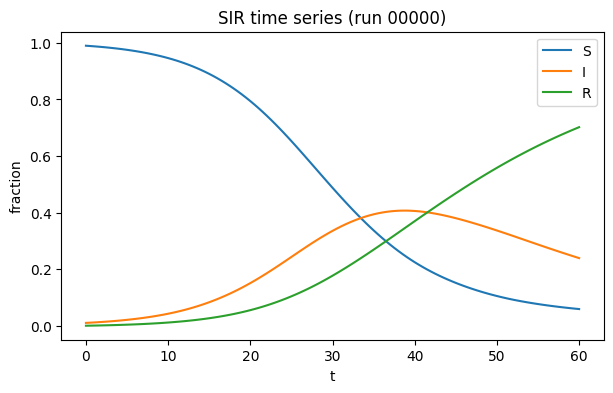

In [17]:
# Plot S, I, R time series for the first run
fig, ax = plt.subplots(figsize=(7, 4))
first_df[["S", "I", "R"]].plot(ax=ax)
ax.set_title(f"SIR time series (run {first})")
ax.set_xlabel("t")
ax.set_ylabel("fraction")
ax.legend(loc="best")
plt.show()

## Heatmaps over the (beta, gamma) grid

In [18]:
# Summarize runs into a DataFrame for plotting
summaries = []
for rid in traj.list_runs():
    params = traj.get_run_params(rid)
    res = traj.get_run_results(rid)
    summaries.append({
        "run_id": rid,
        "beta": float(params["sir.beta"]),
        "gamma": float(params["sir.gamma"]),
        "peak_infected": float(res["sir.peak_infected"]),
        "final_susceptible": float(res["sir.final_susceptible"]),
    })
summary_df = pd.DataFrame(summaries).sort_values(["beta", "gamma"]).reset_index(drop=True)
summary_df

,run_id,beta,gamma,peak_infected,final_susceptible
0,00000,0.2,0.05,0.406987,0.058906
1,00001,0.2,0.10,0.158549,0.316513
2,00002,0.3,0.05,0.537019,0.005690
3,00003,0.3,0.10,0.304235,0.067565
4,00004,0.4,0.05,0.616531,0.000746
5,00005,0.4,0.10,0.406519,0.020782


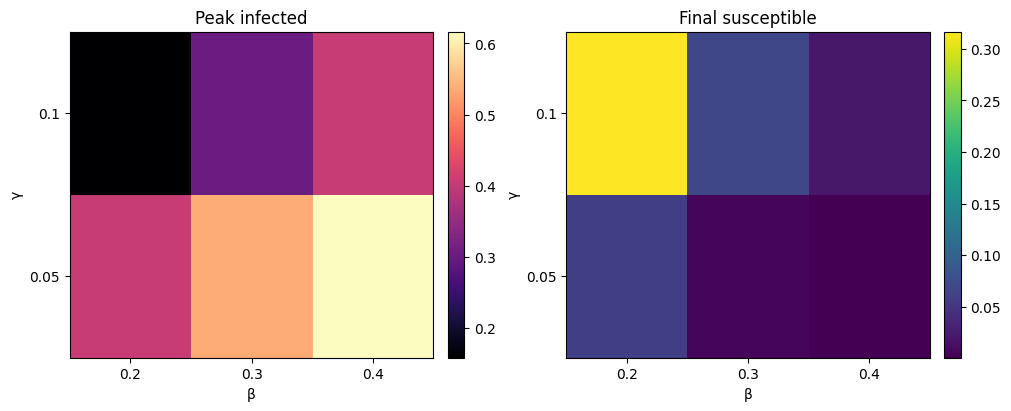

In [19]:
# Heatmaps: peak_infected and final_susceptible over (beta, gamma)
betas = sorted(summary_df["beta"].unique())
gammas = sorted(summary_df["gamma"].unique())

peak_grid = summary_df.pivot(index="gamma", columns="beta", values="peak_infected").loc[gammas, betas]
final_grid = summary_df.pivot(index="gamma", columns="beta", values="final_susceptible").loc[gammas, betas]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(peak_grid.values, origin="lower", aspect="auto", cmap="magma")
axes[0].set_title("Peak infected")
axes[0].set_xlabel("β")
axes[0].set_ylabel("γ")
axes[0].set_xticks(range(len(betas)))
axes[0].set_xticklabels(betas)
axes[0].set_yticks(range(len(gammas)))
axes[0].set_yticklabels(gammas)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(final_grid.values, origin="lower", aspect="auto", cmap="viridis")
axes[1].set_title("Final susceptible")
axes[1].set_xlabel("β")
axes[1].set_ylabel("γ")
axes[1].set_xticks(range(len(betas)))
axes[1].set_xticklabels(betas)
axes[1].set_yticks(range(len(gammas)))
axes[1].set_yticklabels(gammas)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()

## Time-series small multiples across parameter grid

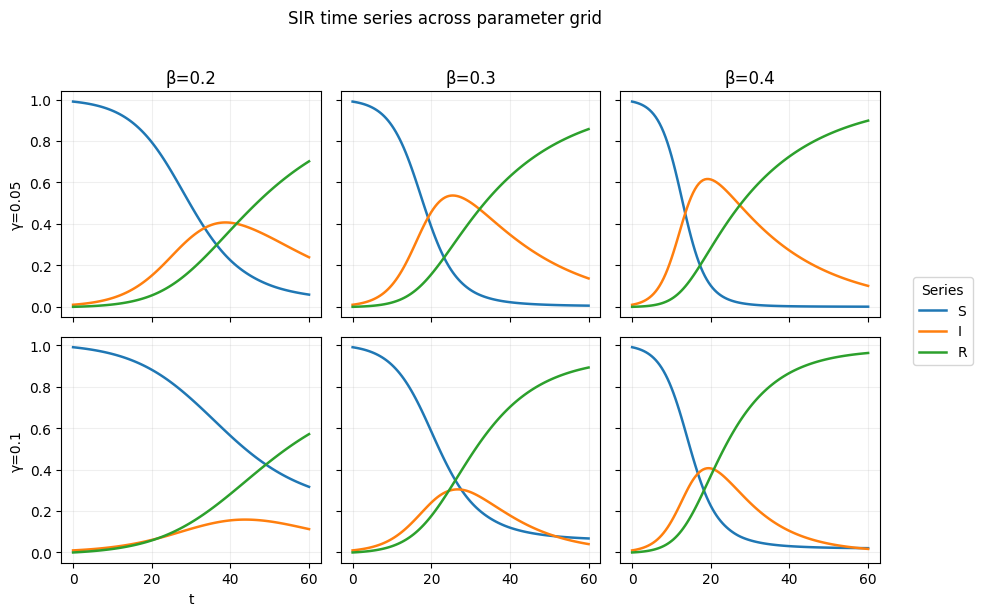

In [20]:
# Small multiples of S(t), I(t), R(t) across (beta, gamma)
# Build mapping from (beta, gamma) -> timeseries
betas = sorted(summary_df["beta"].unique())
gammas = sorted(summary_df["gamma"].unique())
series_map = {}
for rid in traj.list_runs():
    params = traj.get_run_params(rid)
    key = (float(params["sir.beta"]), float(params["sir.gamma"]))
    df = traj.get_run_results(rid)["sir.timeseries"]
    series_map[key] = df

nrows, ncols = len(gammas), len(betas)
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)
for i, g in enumerate(gammas):
    for j, b in enumerate(betas):
        ax = axes[i, j]
        df = series_map[(b, g)]
        ax.plot(df.index, df["S"], color="C0", lw=1.8, label="S")
        ax.plot(df.index, df["I"], color="C1", lw=1.8, label="I")
        ax.plot(df.index, df["R"], color="C2", lw=1.8, label="R")
        ax.grid(alpha=0.2)
        if i == 0:
            ax.set_title(f"β={b}")
        if j == 0:
            ax.set_ylabel(f"γ={g}")
axes[-1, 0].set_xlabel("t")

# Global legend on the right for S/I/R
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="C0", lw=1.8, label="S"),
    Line2D([0], [0], color="C1", lw=1.8, label="I"),
    Line2D([0], [0], color="C2", lw=1.8, label="R"),
]
fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), title="Series", borderaxespad=0.0)
fig.subplots_adjust(right=0.85)

fig.suptitle("SIR time series across parameter grid", y=1.02)
plt.tight_layout()
plt.show()

## Scatter plots summarizing metrics

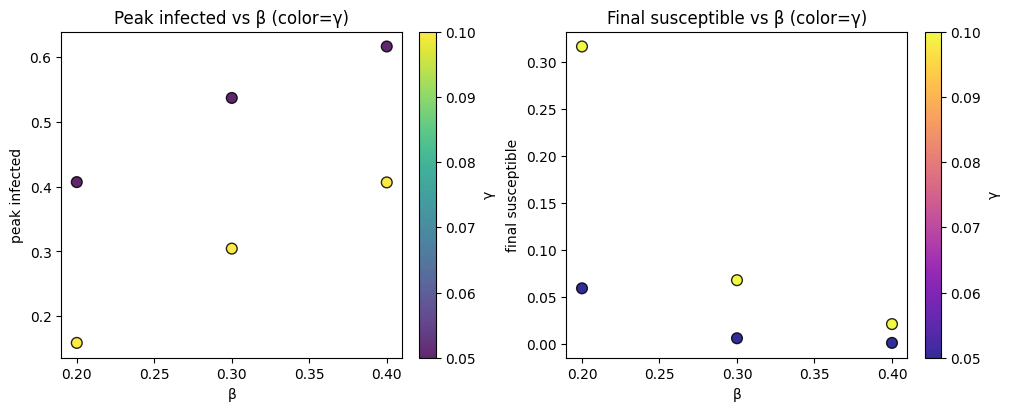

In [21]:
# Scatter plots: beta vs metrics, colored by gamma
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

sc1 = axes[0].scatter(
    summary_df["beta"], summary_df["peak_infected"], c=summary_df["gamma"],
    cmap="viridis", s=60, edgecolor="k", alpha=0.85
)
axes[0].set_title("Peak infected vs β (color=γ)")
axes[0].set_xlabel("β")
axes[0].set_ylabel("peak infected")
cb1 = fig.colorbar(sc1, ax=axes[0])
cb1.set_label("γ")

sc2 = axes[1].scatter(
    summary_df["beta"], summary_df["final_susceptible"], c=summary_df["gamma"],
    cmap="plasma", s=60, edgecolor="k", alpha=0.85
)
axes[1].set_title("Final susceptible vs β (color=γ)")
axes[1].set_xlabel("β")
axes[1].set_ylabel("final susceptible")
cb2 = fig.colorbar(sc2, ax=axes[1])
cb2.set_label("γ")

plt.show()

## Inspect HDF5 and round-trip load

In [22]:
# Inspect the HDF5 file structure and small value previews
print(inspect_h5(str(out_path), show_values=True, show_attrs=True, max_preview=2))

[Group] /trajectories
[Group] /trajectories/sir-sweep-nb
[Group] /trajectories/sir-sweep-nb/parameters
  value = 0.2
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/parameters/sir.beta kind=json json type=float
  value = 0.5
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/parameters/sir.dt kind=json json type=float
  value = 0.1
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/parameters/sir.gamma kind=json json type=float
  value = 0.01
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/parameters/sir.i0 kind=json json type=float
  value = 60.0
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/parameters/sir.t_max kind=json json type=float
[Group] /trajectories/sir-sweep-nb/results
  value = 0.058905782107503996
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-sweep-nb/results/by_run.00000.sir.final_susceptible kind=json json type=float
  value = 0.4069872649162018
  attrs={'kind': "'json'"}
[Group] /trajectories/sir-